# Machine Translation + Transformer

<img src = "../figures/transformer1.png" >

In [1]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from datasets import load_dataset, DatasetDict
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import math

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
torch.__version__

'2.5.1'

In [3]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to Hindi.

## Dataset : Hind EnCorp
HindEnCorp is a comprehensive resource for Hindi-English machine translation and bilingual NLP research, offering both aligned sentence pairs and large-scale Hindi monolingual data.

## Authors
The HindEnCorp project was led by researchers at Charles University in Prague (Czech Republic), particularly from the Institute of Formal and Applied Linguistics (UFAL). The main authors cited in the LREC 2014 publication are:

- Aleš Tamchyna
- Ondřej Bojar
- Petr Rychlý
- Jan Hajič

In [5]:
# Load dataset
dataset = load_dataset("pary/hind_encorp", trust_remote_code=True, split="train").select(range(10000))

# Shuffle dataset before splitting
dataset = dataset.shuffle(seed=42)

# Define split sizes
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))

# Split dataset
train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, train_size + val_size))
test_dataset = dataset.select(range(train_size + val_size, len(dataset)))

# Store in a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 8000, Validation size: 1000, Test size: 1000


## 2. EDA - simple investigation

In [6]:
dataset['train']['translation'][0]

{'en': 'Mara River', 'hi': 'मारा नदी'}

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [7]:
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'hi'

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [8]:
UNK_IDX = 0
PAD_IDX = 1
SOS_IDX = 2
EOS_IDX = 3
SPECIAL_TOKENS = ['<unk>', '<pad>', '<sos>', '<eos>']

In [9]:
class Tokenizer:
    def __init__(self, texts, language='en'):
        
        self.language = language
        self.word2idx = {'<unk>': UNK_IDX, '<pad>': PAD_IDX, '<sos>': SOS_IDX, '<eos>': EOS_IDX}
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.vocab_size = len(SPECIAL_TOKENS)
        
        
        # Build vocabulary
        word_freq = Counter()
        for i, text in enumerate(texts):
            if i % 10000 == 0:
            
            # Apply language-specific normalization
             if language == 'en':
                text = text.lower()
            
            words = text.split()
            word_freq.update(words)
        
        # Add most common words to vocabulary
        for word, freq in word_freq.most_common(50000 - len(SPECIAL_TOKENS)):
            if word not in self.word2idx:
                self.word2idx[word] = self.vocab_size
                self.idx2word[self.vocab_size] = word
                self.vocab_size += 1      
    
    def encode(self, text):
        if self.language == 'en':
            text = text.lower()
        words = text.split()
        return [SOS_IDX] + [self.word2idx.get(word, UNK_IDX) for word in words] + [EOS_IDX]
    
    def decode(self, indices):
        return ' '.join([self.idx2word.get(idx, '<unk>') for idx in indices if idx not in [PAD_IDX, SOS_IDX, EOS_IDX]])

In [10]:
# create tokens
src_texts = [sample['translation']['en'] for sample in dataset['train']]
trg_texts = [sample['translation']['hi'] for sample in dataset['train']]
src_tokenizer = Tokenizer(src_texts, language='en')
trg_tokenizer = Tokenizer(trg_texts, language='hi')

In [11]:
sample = dataset['train'][0]

tokens_en = src_tokenizer.encode(sample['translation']['en'])
tokens_hi = trg_tokenizer.encode(sample['translation']['hi'])

print("English tokens:", tokens_en)
print("Hindi tokens:", tokens_hi)

English tokens: [2, 7265, 979, 3]
Hindi tokens: [2, 1863, 412, 3]


In [12]:
print("Token to text (English):",src_tokenizer.decode(tokens_en))
print("Token to text (Hindi):",src_tokenizer.decode(tokens_hi))

Token to text (English): mara river
Token to text (Hindi): philosophy 5


## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [13]:
# convert TranslationDataset class to function
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, dataset_split, src_tokenizer, trg_tokenizer, max_len=2000):
        self.examples = dataset_split
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        example = self.examples[idx]
        src_text = example['translation']['en']
        trg_text = example['translation']['hi']
        
        src_tokens = self.src_tokenizer.encode(src_text)[:self.max_len]
        trg_tokens = self.trg_tokenizer.encode(trg_text)[:self.max_len]
        
        return torch.tensor(src_tokens), torch.tensor(trg_tokens)

In [14]:
train_dataset = TranslationDataset(dataset['train'], src_tokenizer, trg_tokenizer)
valid_dataset = TranslationDataset(dataset['val'], src_tokenizer, trg_tokenizer)
test_dataset = TranslationDataset(dataset['test'], src_tokenizer, trg_tokenizer)

In [15]:
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)
    
    # Pad sequences to the maximum length in the batch
    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    
    return src_batch, trg_batch

In [16]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [17]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.positionwise_feedforward = nn.Sequential(nn.Linear(hid_dim, pf_dim),nn.ReLU(),nn.Dropout(dropout),nn.Linear(pf_dim, hid_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        return src

### Encoder

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, attn_variant, device, max_length=500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device) for _ in range(n_layers) ])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):
        batch_size = src.shape[0]
        src_len = src.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [19]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, attn_variant, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_variant = attn_variant
        self.device = device
        
        # Initialize layers based on attention variant
        if attn_variant == 'multiplicative':
            self.W = nn.Linear(self.head_dim, self.head_dim)
        elif attn_variant == 'additive':
            self.Wa = nn.Linear(self.head_dim, self.head_dim)
            self.Ua = nn.Linear(self.head_dim, self.head_dim)
            self.V = nn.Linear(self.head_dim, 1)
        # General attention doesn't need additional parameters
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Split into heads
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Calculate attention scores based on variant
        if self.attn_variant == 'multiplicative':
            # Multiplicative attention
            K_transformed = self.W(K)
            energy = torch.matmul(Q, K_transformed.transpose(-2, -1)) / self.scale
            
        elif self.attn_variant == 'general':
            # General attention
            energy = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
            
        elif self.attn_variant == 'additive':
            # Additive attention
            Q_transformed = self.Wa(Q)
            K_transformed = self.Ua(K)
            
            # Expand dimensions for broadcasting
            Q_expanded = Q_transformed.unsqueeze(-2)  # [batch, heads, query_len, 1, head_dim]
            K_expanded = K_transformed.unsqueeze(-3)  # [batch, heads, 1, key_len, head_dim]
            
            # Calculate additive attention
            energy = torch.tanh(Q_expanded + K_expanded)  # [batch, heads, query_len, key_len, head_dim]
            energy = self.V(energy).squeeze(-1)  # [batch, heads, query_len, key_len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1)
        attention = self.dropout(attention)
        
        x = torch.matmul(attention, V)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)
        
        return x, attention

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.positionwise_feedforward = nn.Sequential(nn.Linear(hid_dim, pf_dim),nn.ReLU(),nn.Dropout(dropout),nn.Linear(pf_dim, hid_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        _trg = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        return trg, attention

### Decoder

In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, attn_variant, device, max_length=500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([
            DecoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
            for _ in range(n_layers)
        ])
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        output = self.fc_out(trg)
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [22]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask
        
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output, attention

## 6. Training

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [23]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    step = 0
    
    for src, trg in loader:
        
        step += 1
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length


Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [24]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for src,  trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [25]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
attention = ['general','multiplicative',  'additive']

In [27]:
# Initialize Encoder and Decoder
INPUT_DIM = src_tokenizer.vocab_size
OUTPUT_DIM = trg_tokenizer.vocab_size
HID_DIM = 256
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 256
DEC_PF_DIM = 256
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [61]:
results = {
        'Attention Type': [],
        'Training Loss': [],
        'Training PPL': [],
        'Validation Loss': [],
        'Validation PPL': [],
        'Training Time': []
    }

In [34]:
import pickle

In [36]:
import torch.optim as optim
import matplotlib.pyplot as plt

epochs=3
clip=1
lr = 0.0005

for attn_variant in attention:
    print("Attention : ",attn_variant)
    start_training_time = time.time()
    
    enc = Encoder(INPUT_DIM, 
                  HID_DIM, 
                  ENC_LAYERS, 
                  ENC_HEADS, 
                  ENC_PF_DIM, 
                  ENC_DROPOUT, 
                  attn_variant, 
                  device)
    
    dec = Decoder(OUTPUT_DIM, 
                  HID_DIM, 
                  DEC_LAYERS, 
                  DEC_HEADS, 
                  DEC_PF_DIM, 
                  DEC_DROPOUT, 
                  attn_variant, 
                  device)
    
    model = Seq2SeqTransformer(enc, dec, PAD_IDX, PAD_IDX, device).to(device)    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} ")
        train_loss = train(model, train_loader, optimizer, criterion, clip, len(train_loader))
        valid_loss = evaluate(model, valid_loader, criterion, len(valid_loader))
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print(f"New best validation loss: {valid_loss:.4f}")
            torch.save(model.state_dict(), f'model-{attn_variant}.pt')
        
        print(f'Epoch: {epoch+1:02}')
        print(f'Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')
    
    # Calculate final metrics
    training_time = time.time() - start_training_time
    print("Training Time: ",training_time,"\n\n")
    
    model_name=f'model-{attn_variant}.pkl'
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
    # Store results
    results['Attention Type'].append(attn_variant)
    results['Training Loss'].append(f"{train_losses[-1]:.3f}")
    results['Training PPL'].append(f"{math.exp(train_losses[-1]):.3f}")
    results['Validation Loss'].append(f"{valid_losses[-1]:.3f}")
    results['Validation PPL'].append(f"{math.exp(valid_losses[-1]):.3f}")
    results['Training Time'].append(f"{training_time/60:.1f}m")
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.title(f'Training and Validation Losses ({attn_variant} Attention)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{attn_variant}_loss.png')
    plt.close()

Attention :  general
Epoch 1 
New best validation loss: 7.0801
Epoch: 01
Train Loss: 7.425 | Train PPL: 1677.404
Val. Loss: 7.080 | Val. PPL: 1188.065
Epoch 2 
New best validation loss: 6.8883
Epoch: 02
Train Loss: 6.584 | Train PPL: 723.569
Val. Loss: 6.888 | Val. PPL: 980.698
Epoch 3 
New best validation loss: 6.8189
Epoch: 03
Train Loss: 6.073 | Train PPL: 433.946
Val. Loss: 6.819 | Val. PPL: 914.948
Training Time:  884.9905552864075 


Attention :  multiplicative
Epoch 1 
New best validation loss: 7.0461
Epoch: 01
Train Loss: 7.398 | Train PPL: 1632.610
Val. Loss: 7.046 | Val. PPL: 1148.366
Epoch 2 
New best validation loss: 6.8167
Epoch: 02
Train Loss: 6.575 | Train PPL: 716.910
Val. Loss: 6.817 | Val. PPL: 912.947
Epoch 3 
New best validation loss: 6.7694
Epoch: 03
Train Loss: 6.075 | Train PPL: 434.997
Val. Loss: 6.769 | Val. PPL: 870.799
Training Time:  928.3740427494049 


Attention :  additive
Epoch 1 
New best validation loss: 6.9655
Epoch: 01
Train Loss: 7.402 | Train PPL: 

In [104]:
# save tokenizers
file_name=f'src_tokenizer.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(src_tokenizer, f)

file_name=f'trg_tokenizer.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(trg_tokenizer, f)

In [74]:
import pandas as pd

In [75]:
results_df = pd.DataFrame(results)

In [76]:
results_df

,Attention Type,Training Loss,Training PPL,Validation Loss,Validation PPL,Training Time
0,general,6.073,433.946,6.819,914.948,884.990555
1,multiplicative,6.075,434.997,6.769,870.799,928.374043
2,additive,5.869,353.777,6.718,826.957,2992.822583


| **Attentions**              | **Training Loss** | **Training PPL** | **Validation Loss** | **Validation PPL** |
|-----------------------------|-------------------|------------------|---------------------|--------------------|
| General Attention           |      6.073             |  433.946                |   6.819                 |    914.948                 |
| Multiplicative Attention    |      6.075             |  434.997                |   6.769                  |    870.799               |
| Additive Attention          |      5.869             |  353.777                |   6.718                  |      826.957              |


### Key Observations
Additive Attention achieves:

- Lowest Training Loss (5.869)
- Lowest Training PPL (353.777)
- Lowest Validation Loss (6.718)
- Lowest Validation PPL (826.957)

Multiplicative Attention is second in performance:

Very close to General Attention in Training Loss and Training PPL. <br/>

Slightly better than General Attention in Validation Loss (6.769 < 6.819) and Validation PPL (870.799 < 914.948).<br/>
General Attention places third among the three in validation metrics, although its training metrics are nearly tied with Multiplicative.

<img src = "./loss_plots/general_loss.png" >
<img src = "./loss_plots/multiplicative_loss.png" >
<img src = "./loss_plots/additive_loss.png" >

- Additive Attention tends to learn more expressive alignment patterns. This often translates into better capture of context, especially with languages that have complex grammar (like Hindi).
- Multiplicative and General rely on dot-product or a linear transformation, which can be computationally cheaper but sometimes less flexible. While both can still yield good results, the alignment might be less nuanced compared to Additive Attention.
- Because the Additive model has lower perplexity (PPL), it likely produces more coherent translations and handles vocabulary/structure alignment better. For English-Hindi translation—which can involve significant reordering of words and morphological changes—Additive’s capacity to learn more nuanced alignments is an advantage.

### Computational Efficiency
- Multiplicative (Dot-Product) and General Attention : They are typically faster than Additive because they rely on relatively simple matrix multiplications (dot products). Fewer parameters than Additive, especially if using plain dot-product.
- Additive Attention :Involves a feed-forward network to combine query and key vectors. This adds more learnable parameters (a small MLP) and, in some cases, can be slower.However, modern hardware (especially GPUs) handles these operations well, so the difference might not be drastic unless the dataset is very large or the model is extremely big.

In [31]:
with open('../app/server/models/src_tokenizer.pkl', 'rb') as f:
    loaded_src_tokenizer = pickle.load(f)

In [32]:
with open('../app/server/models/src_tokenizer.pkl', 'rb') as f:
    loaded_trg_tokenizer = pickle.load(f)

In [65]:
sample = ["How are you?", "आप कैसे हैं?"]

In [66]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    # Convert attention to list if it's a NumPy array
    attention = attention.tolist()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    # Split sentence and translation into lists of words/tokens
    sentence_tokens = sentence.split()
    translation_tokens = translation.split()
    
    # Add empty string for formatting and concatenate with tokens
    y_ticks =  [''] + translation_tokens
    x_ticks =  [''] + sentence_tokens
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


In [76]:
def show_attention(model):
    with torch.no_grad():
        # Tokenize
        src_tokens = torch.tensor([src_tokenizer.encode(sample[0])]).to(device)
        trg_tokens = torch.tensor([trg_tokenizer.encode(sample[1])]).to(device)
        
        # Get model output and attention
        output, attention_weights = model(src_tokens, trg_tokens[:,:-1])
        
        # Get last layer attention
        if isinstance(attention_weights, list):
            last_layer_attention = attention_weights[-1]
        else:
            last_layer_attention = attention_weights
            
        # Get first head's attention from first batch
        attention = last_layer_attention[0, 0].cpu().numpy()
        
        # Get tokens
        src_tokens_list = src_tokenizer.encode(sample[0])
        trg_tokens_list = trg_tokenizer.encode(sample[1])
        
        # Convert token IDs to text
        src_tokens_text = [src_tokenizer.decode([token]) for token in src_tokens_list]
        trg_tokens_text = [trg_tokenizer.decode([token]) for token in trg_tokens_list]
        
        # Remove special tokens
        src_tokens_text = [t for t in src_tokens_text if t not in ['<pad>', '<sos>', '<eos>', '']]
        trg_tokens_text = [t for t in trg_tokens_text if t not in ['<pad>', '<sos>', '<eos>', '']]
        
        # Display attention for general model
        display_attention(sample[0], sample[1], attention)



In [77]:
import warnings
warnings.filterwarnings("ignore")

In [78]:
with open('../app/server/models/model-general.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

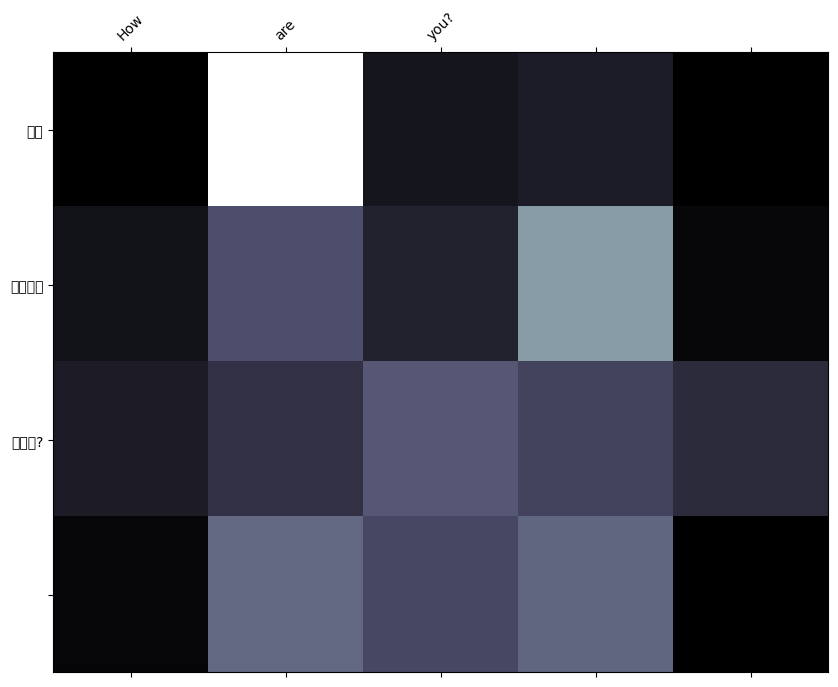

In [79]:
show_attention(loaded_model)

In [80]:
with open('../app/server/models/model-multiplicative.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

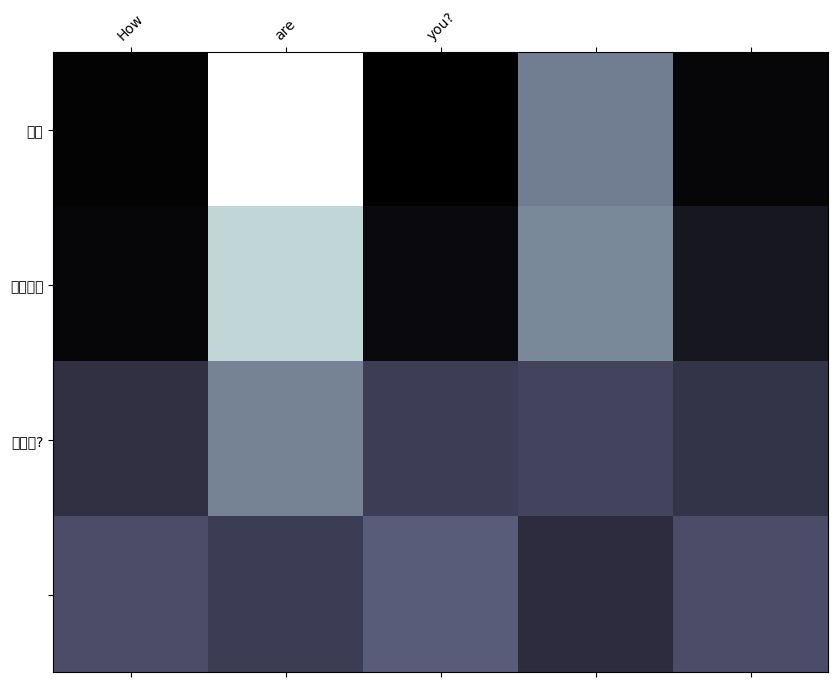

In [81]:
show_attention(loaded_model)

In [82]:
with open('../app/server/models/model-additive.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

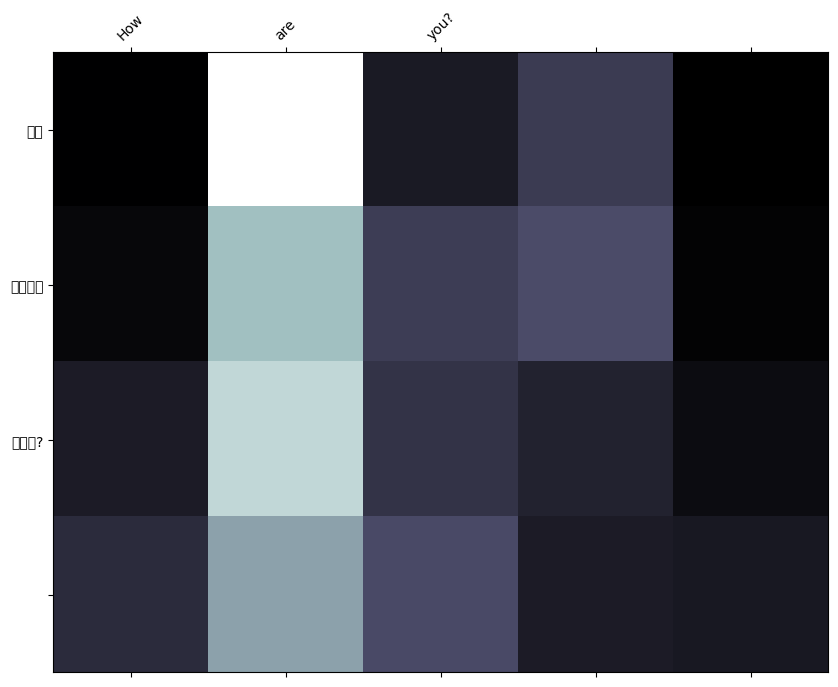

In [83]:
show_attention(loaded_model)